In [39]:
#!pip install opencv-python
#!pip install sklearn

# !sudo swapon -s
# !sudo dd if=/dev/zero of=/swapfile bs=4000 count=4000k
# !sudo mkswap /swapfile
# !sudo swapon /swapfile

In [40]:
#Import library
import glob
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, color, exposure
import matplotlib.image as mpimg
import cv2

from pathlib import Path
from numpy import *
import numpy as np
import os
import random

from sklearn.model_selection import train_test_split

import csv
import datetime
import pickle

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import cpuinfo
import math

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

from sklearn.externals.joblib import dump, load


# Declare parameters

In [41]:
pc_name = cpuinfo.cpu.info[0]['ProcessorNameString']

parameter = {
    'orientations' : 9,
    'pixels_per_cell' : (8,8),
    'cells_per_block' : (1,1)
}


start_time = datetime.datetime.now().strftime("%d %B %Y - %I:%M%p")

directory_model = './Model-HL-WajahBG-Revisi/'
id_model = 'b22649a5-030a-4931-982f-9744adc1b54b'
path_model = directory_model+id_model+'.pkl'

path_image = './gambar kucing fix bg/test/Non_Scottish(171).jpg'


In [42]:
print('Parameter : ')
for i in parameter:
    print(i," : ", parameter[i])

print('\n')
print('pc_name : '+pc_name)
print('start_time : '+start_time)

print('\n')
print('path_model : '+path_model)

Parameter : 
orientations  :  9
pixels_per_cell  :  (8, 8)
cells_per_block  :  (1, 1)


pc_name : Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz
start_time : 14 August 2019 - 09:12AM


path_model : ./Model-HL-WajahBG-Revisi/b22649a5-030a-4931-982f-9744adc1b54b.pkl


## Load Dataset

In [43]:
def readImage(path):
    return np.asarray(plt.imread(path))

def resizeImage(image,size=(100,100), interpolation = cv2.INTER_LINEAR):
    image = cv2.resize(image, size, interpolation=interpolation)
    return np.asarray(image)

def grayscaleImage(image):
    image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    return np.asarray(image)

In [44]:
image = readImage(path_image)

imageResized = resizeImage(image)

imageGray = grayscaleImage(imageResized)

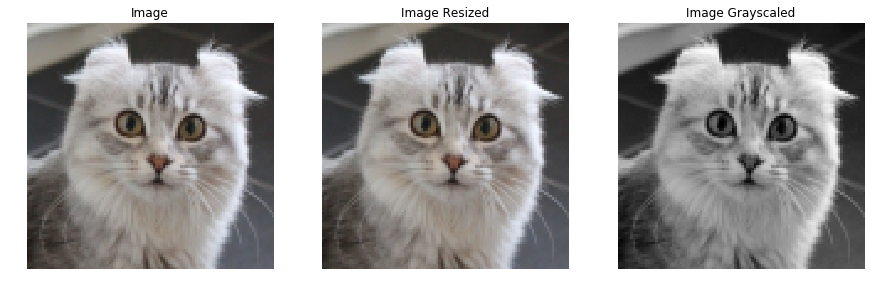

In [45]:
#Preview data
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1,3,1)
ax.set_title('Image')
ax.set_axis_off()
ax.imshow(image)

ax = fig.add_subplot(1,3,2)
ax.set_title('Image Resized')
ax.set_axis_off()
ax.imshow(imageResized)

ax = fig.add_subplot(1,3,3)
ax.set_title('Image Grayscaled')
ax.set_axis_off()
ax.imshow(imageGray, cmap='gray')


In [46]:
# dx, dy = 10,10

# # Custom (rgb) grid color
# grid_color = [0]
# img = imageGray[:]
# # Modify the image to include the grid
# img[:,::dy] = grid_color
# img[::dx,:] = grid_color

# # Show the result
# plt.imshow(img, cmap='gray')
# plt.show()

In [47]:
imageGray.shape

(100, 100)

Gabungkan file kemudian acak semua data untuk train dan test

# HOG PROCESS

In [48]:
# parameter
cell = parameter['pixels_per_cell']
incr = cell
bin_num = parameter['orientations']
block = parameter['cells_per_block']

im_size = [100,100]
def hog_non_library(image):
    image = np.asarray(image)
    gamma_correction = 1.5
    image = cv2.equalizeHist((np.power(image/255., gamma_correction)*255).astype(np.uint8))

    gx = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=1)
    gy = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=1)
    
    mag, grad = cv2.cartToPolar(gx, gy, angleInDegrees=True)
    
    #GENERATE HOG
    #======================================
    grad_array = np.asarray(grad)
    mag_array = np.asarray(mag)
    max_h = int(((grad_array.shape[0]-cell[0])/incr[0])+1)
    max_w = int(((grad_array.shape[1]-cell[1])/incr[1])+1)
    
    cell_array = []
    w = 0
    h = 0
    i = 0
    j = 0
    
    # make cell with (n x n) pixel
    #proses get histogram dari nilai gradient & magnitude
    while i<max_h:
        w = 0
        j = 0

        while j<max_w:
            for_hist = grad_array[h:h+cell[0],w:w+cell[1]]
            for_wght = mag_array[h:h+cell[0],w:w+cell[1]]

            bins_range = (0, 180)
            bins = bin_num
            hist,_ = np.histogram(for_hist,bins=bins,range=bins_range,weights=for_wght)

            val = hist

            cell_array.append(val)
            j += 1
            w += incr[1]

        i += 1
        h += incr[0]
        #sampai sini
        
        
    cell_array = np.reshape(cell_array,(max_h, max_w, bin_num))
    max_h = int((max_h-block[0])+1)
    max_w = int((max_w-block[1])+1)
    block_list = []
    w = 0
    h = 0
    i = 0
    j = 0
    
    while i<max_h:
        w = 0
        j = 0

        while j<max_w:
            for_norm = cell_array[h:h+block[0],w:w+block[1]]
            mag = np.linalg.norm(for_norm)
            arr_list = (for_norm/mag).flatten().tolist()
            block_list += arr_list
            j += 1
            w += 1
        i += 1
        h += 1
        
    hog_features = np.asarray(block_list,dtype=float)
    
    return hog_features, grad, mag
   

def hog_In(image):
    
    _, image_hog = hog(image, 
                   orientations=parameter['orientations'], 
                   pixels_per_cell=parameter['pixels_per_cell'], 
                   cells_per_block=parameter['cells_per_block'], 
                   visualise=True, 
                   feature_vector = True
                  )
    
    feature, grad_hog, mag_hog = hog_non_library(image)
    
    return feature, grad_hog, mag_hog, image_hog

In [49]:
feature, gradient, magnitude, visualHog = hog_In(imageGray)

In [50]:
g = np.asarray(gradient).astype(dtype='int')
v = np.asarray(visualHog).astype(dtype='int')

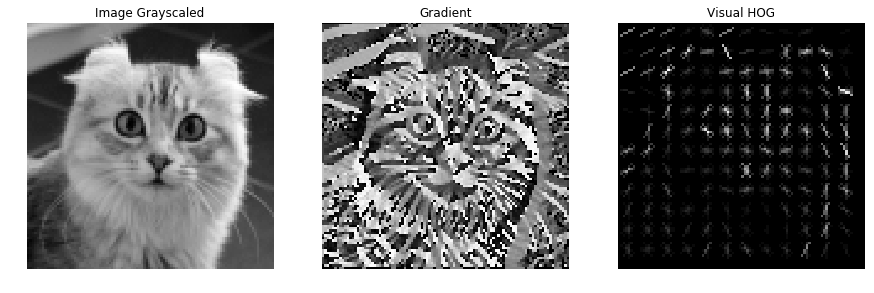

In [51]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1,3,1)
ax.set_title('Image Grayscaled')
ax.set_axis_off()
ax.imshow(imageGray, cmap='gray')

ax = fig.add_subplot(1,3,2)
ax.set_title('Gradient')
ax.set_axis_off()
ax.imshow(g, cmap='gray')

ax = fig.add_subplot(1,3,3)
ax.set_title('Visual HOG')
ax.set_axis_off()
ax.imshow(v, cmap='gray')

In [52]:
# check the nan value from feature list
feature[np.isnan(feature)] = 0
    


# Load Saved Model

In [53]:
clf = load(path_model) 

In [54]:
x_test = []
x_test.append(feature)
x_test = np.asarray(x_test)

In [55]:
y = clf.predict(x_test)

In [56]:
def generateClass(y_pred):
    y_expect = ''
    if y_pred == 0:
        y_expect = 'Scottish'
    elif y_pred == 1:
        y_expect = 'Non_Scottish'
    return str(y_expect)

In [57]:
print("Hasil Prediksi : "+ generateClass(y[0]))

Hasil Prediksi : Non_Scottish
